# TP53 Graph Classification - Main Experiment
Predicting TP53 mutation status using single-cell RNA-seq and Graph Neural Networks.


## Setup

In [ ]:
import os
import sys
import scanpy as sc
import anndata as ad
import mygene
sys.path.append(os.path.abspath("../src"))

import load_data

## Data import 

In [12]:
adata = load_data.load_expression_data( "../data/Expression_Matrix", verbosity=True)
df_expression=ad.AnnData.to_df(adata)
df_expression.head()

df_expression shape: (35276, 47096)
df_expression columns: Index(['ENSG00000000003', 'ENSG00000000419', 'ENSG00000000457',
       'ENSG00000000460', 'ENSG00000001036', 'ENSG00000001084',
       'ENSG00000001167', 'ENSG00000001460', 'ENSG00000001461',
       'ENSG00000001497',
       ...
       'ENSG00000271681', 'ENSG00000276605', 'ENSG00000277206',
       'ENSG00000277591', 'ENSG00000278658', 'ENSG00000279270',
       'ENSG00000280920', 'ENSG00000283420', 'ENSG00000284003',
       'ENSG00000284685'],
      dtype='object', length=47096)
df_expression head:                     ENSG00000000003  ENSG00000000419  ENSG00000000457  \
AU565_AAACCAGTTTGG              0.0              2.0              0.0   
AU565_AAACGTGCAGCG              1.0              0.0              0.0   
AU565_AAAGCCACATGC              0.0              2.0              0.0   
AU565_AAAGTCGGCTGG              0.0              0.0              0.0   
AU565_AAAGTGCCTAAA              0.0              2.0              0.0   

,ENSG00000000003,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,...,ENSG00000271681,ENSG00000276605,ENSG00000277206,ENSG00000277591,ENSG00000278658,ENSG00000279270,ENSG00000280920,ENSG00000283420,ENSG00000284003,ENSG00000284685
AU565_AAACCAGTTTGG,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAACGTGCAGCG,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGCCACATGC,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTCGGCTGG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AU565_AAAGTGCCTAAA,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_mutation = load_data.load_mutation_data("../data/Mutation/CellLineDownload_r21.csv", verbosity=True)
df_mutation = load_data.add_cleaned_column(df_mutation, column_name="Sample_Name")
df_mutation.head()

df_mutation shape: (2913, 80)
df_mutation columns: Index(['Sample_Name', 'ATCC_ID', 'Cosmic_ID', 'Short_topo', 'Morphology',
       'Tumor_origin', 'Add_info', 'Sex', 'Age', 'Country', 'Population',
       'Germline_mutation', 'Infectious_agent', 'Tobacco', 'Alcohol',
       'Exposure', 'KRAS_status', 'Other_mutations', 'TP53status', 'p53_IHC',
       'TP53_LOH', 'MUT_ID', 'hg18_Chr17_coordinates',
       'hg19_Chr17_coordinates', 'hg38_Chr17_coordinates', 'ExonIntron',
       'Codon_number', 'Description', 'Type', 'c_description', 'g_description',
       'g_description_GRCh38', 'WT_nucleotide', 'Mutant_nucleotide',
       'WT_codon', 'Mutant_codon', 'WT_AA', 'Mutant_AA', 'Effect',
       'ProtDescription', 'COSMIClink', 'TCGA_ICGC_GENIE_count', 'Hotspot',
       'AGVGDClass', 'SIFTClass', 'Polyphen2', 'REVEL', 'BayesDel',
       'StructureFunctionClass', 'TransactivationClass', 'DNEclass',
       'DNE_LOFclass', 'WAF1nWT', 'MDM2nWT', 'BAXnWT', 'AIP1nWT', 'h1433snWT',
       'GADD45nWT

,Sample_Name,ATCC_ID,Cosmic_ID,Short_topo,Morphology,Tumor_origin,Add_info,Sex,Age,Country,...,exon3,exon4,exon5,exon6,exon7,exon8,exon9,exon10,exon11,Sample_Name_cleaned
Sample_ID,,,,,,,,,,,,,,,,,,,,,
2946,SW13,CCL-105,909744.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,55.0,NaN,...,False,False,True,True,True,True,False,False,False,SW13
24833,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,False,False,True,True,True,True,False,False,False,NCIH295
24979,NCI-H295R,CRL-2128,NaN,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),primary,Derived from NCI-H295 cell line,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295R
21569,NCI-H295,CRL-10296,908466.0,ADRENAL GLAND,Adrenal cortical carcinoma (C74.0),NaN,NaN,F,48.0,NaN,...,True,True,True,True,True,True,True,True,True,NCIH295
21329,ETK-1,NaN,906861.0,BILIARY TRACT,"Adenocarcinoma, NOS",NaN,NaN,F,NaN,NaN,...,True,True,True,True,True,True,True,True,True,ETK1


In [14]:
load_data.check_on_cell_lines_correspondence(df_expression, df_mutation, "Sample_Name_cleaned")

Number matching lines: 31833
Percentage of matching cell: 90.24%


# EDA

In [22]:
"""
Aggiungi codice riguardo Mygene
"""

mg = mygene.MyGeneInfo()
ensembl_ids = adata.var["gene_symbols"].tolist()
query = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol,name", species="human")

id_to_symbol = {r['query']: r.get('symbol', r['query']) for r in query}

adata.var['gene_symbols_mapped'] = adata.var['gene_symbols'].map(id_to_symbol)




Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
22 input query terms found dup hits:	[('ENSG00000215156', 2), ('ENSG00000227110', 2), ('ENSG00000228566', 2), ('ENSG00000280018', 2), ('E
928 input query terms found no hit:	['ENSG00000112096', 'ENSG00000130723', 'ENSG00000168078', 'ENSG00000189144', 'ENSG00000205485', 'ENS


In [24]:
adata.var['mt'] = adata.var['gene_symbols_mapped'].str.startswith('MT-')

In [28]:
print(adata.var['gene_symbols_mapped'].unique()[:20])

['TSPAN6' 'DPM1' 'SCYL3' 'FIRRM' 'FUCA2' 'GCLC' 'NFYA' 'STPG1' 'NIPAL3'
 'LAS1L' 'SEMA3F' 'ANKIB1' 'CYP51A1' 'KRIT1' 'RAD52' 'BAD' 'LAP3' 'MAD1L1'
 'LASP1' 'SNX11']


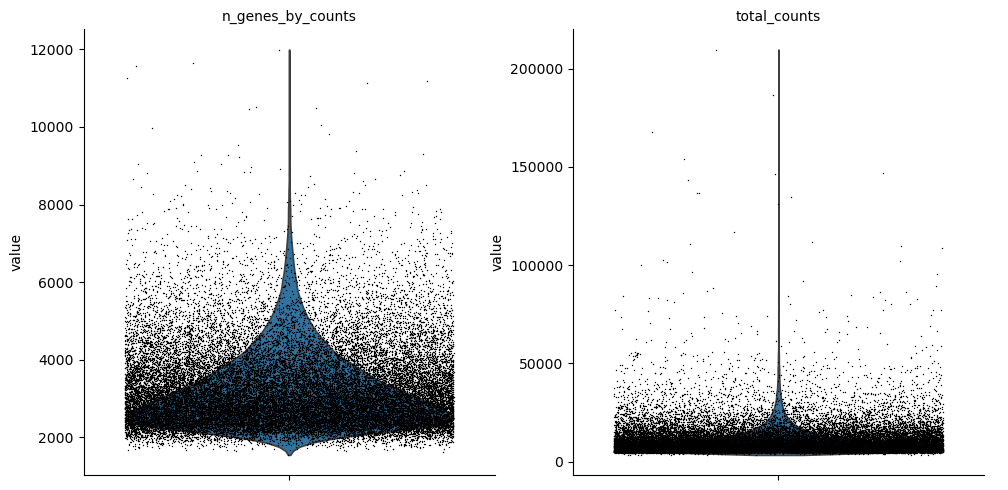

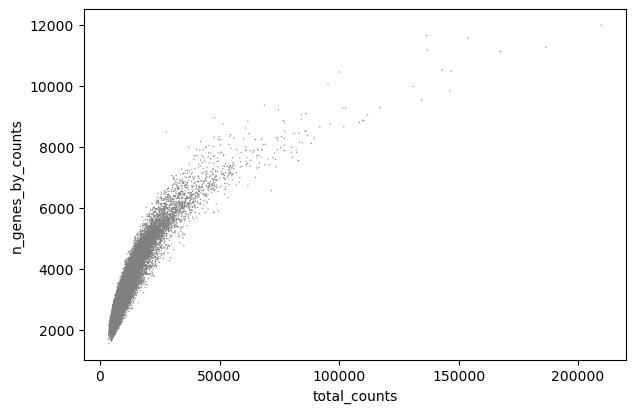

In [29]:

sc.pp.calculate_qc_metrics(
    adata,
    inplace=True,  # aggiunge le metriche direttamente in adata.obs
    log1p=True
)


sc.pl.violin(
    adata,
    ['n_genes_by_counts', 'total_counts'],
    jitter=0.4,
    multi_panel=True
)


sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')